# Plotting the mutations density in the genes

Are there specific genes in which a significant portion of the mutations fall?
We want to answer this by finding the distribution of the number of mutations per gene.
That is, for each integer, we want to know how many genes have that number of mutations.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import optimize

sns.set()

We first map genes to the number of mutations they harbor (read from a random sample of 100,000 mutations)

In [2]:
from collections import Counter
from ICGC_data_parser import SSM_Reader



mutations_per_gene = Counter()

mutations = SSM_Reader(filename='/home/ad115/Downloads/simple_somatic_mutation.aggregated.vcf.gz')

# Fix weird bug due to malformed description headers
mutations.infos['studies'] = mutations.infos['studies']._replace(type='String')

consequences = mutations.subfield_parser('CONSEQUENCE')



for i, record in enumerate(mutations):
    if i % 100000 == 0:
        print(i)
    affected_genes = [c.gene_symbol for c in consequences(record) if c.gene_affected]
    mutations_per_gene.update(affected_genes)
    
mutations_per_gene.most_common(5)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

[('PCDH15', 1014985),
 ('RBFOX1', 817112),
 ('CSMD1', 743708),
 ('DLG2', 592735),
 ('SPOCK3', 525639)]

In [3]:
len(mutations_per_gene)

55754

Now we want to group by number of mutations

In [4]:
distribution = Counter(mutations_per_gene.values())
distribution.most_common(10)

[(188, 145),
 (190, 143),
 (213, 140),
 (179, 139),
 (177, 139),
 (198, 138),
 (206, 137),
 (199, 134),
 (187, 134),
 (192, 134)]

Now we plot the data...

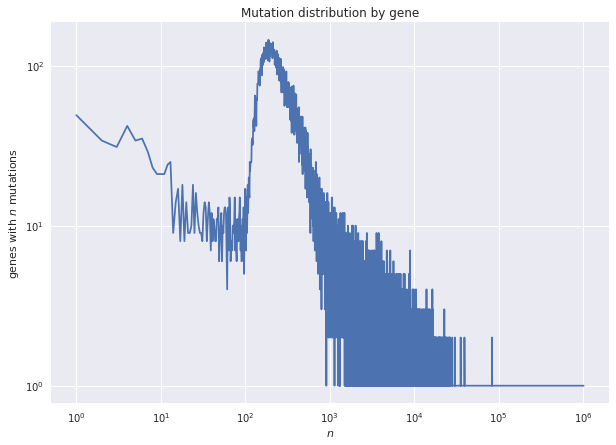

In [5]:
x = sorted(distribution.keys())
y = [distribution[i] for i in x]

plt.figure(figsize=(10, 7))

plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.title('Mutation distribution by gene')
plt.xlabel('$n$')
plt.ylabel('genes with $n$ mutations')
plt.show()

We can see the data resembles a power law but does not quite fit. It looks like it has a bump in the middle, this may be because the genes have wildly varying lengths. In order to correct this we have to normalize the mutations per gene by the length of the gene. This is done as follows:

In [6]:
# In order to find out the length of the 
# genes, we will use the Ensembl REST API.
import ensembl_rest
from itertools import islice

def chunks_of(iterable, size=10):
    """A generator that yields chunks of fixed size from the iterable."""
    iterator = iter(iterable)
    while True:
        next_ = list(islice(iterator, size))
        if next_:
            yield next_
        else:
            break
# ---
        
# Instantiate a client for communication with
# the Ensembl REST API.
client = ensembl_rest.EnsemblClient()


normalized_counts = dict()
lengths_distribution = Counter()
for i, gene_batch in enumerate(chunks_of(mutations_per_gene, size=1000)):
    # Get information of the genes
    gene_data = client.symbol_post('human',
                                   params={'symbols': gene_batch})
    gene_lengths = {gene: data['end'] - data['start'] + 1
                        for gene, data in gene_data.items()}
    lengths_distribution.update(gene_lengths.values())
    
    # Get the normalization
    normalized_counts.update({
        gene: mutations_per_gene[gene] / gene_lengths[gene]
            for gene in gene_data
    })
    
    print((i+1)*1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


In [7]:
c = Counter()
c.update(normalized_counts)
c.most_common(10)

[('IGHD7-27', 639.0),
 ('MIR663A', 456.5483870967742),
 ('IGKJ4', 192.54054054054055),
 ('IGKJ1', 190.89473684210526),
 ('IGKJ3', 189.60526315789474),
 ('IGKJ2', 185.25641025641025),
 ('IGHJ4', 179.93478260869566),
 ('IGKJ5', 178.31578947368422),
 ('IGHJ3P', 174.84),
 ('IGHJ5', 174.0)]

In [8]:
normalized_distribution = Counter(normalized_counts.values())
normalized_distribution.most_common(10)

[(2.0, 18),
 (2.5, 12),
 (3.0, 11),
 (0.5, 11),
 (0.25, 9),
 (0.3333333333333333, 9),
 (0.6666666666666666, 9),
 (1.5, 8),
 (1.4299065420560748, 7),
 (1.0, 7)]

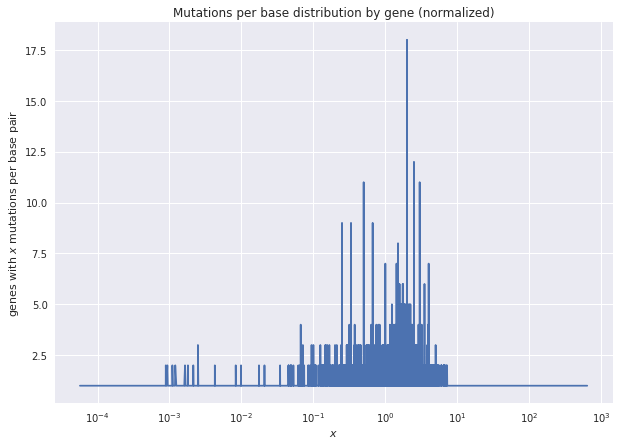

In [9]:
x = sorted(normalized_distribution.keys())
y = [normalized_distribution[i] for i in x]

plt.figure(figsize=(10, 7))

plt.plot(x, y)
plt.xscale('log')
plt.title('Mutations per base distribution by gene (normalized)')
plt.xlabel('$x$')
plt.ylabel('genes with $x$ mutations per base pair')
plt.show()

In [10]:
max(lengths_distribution)

2473537

In [11]:
min(lengths_distribution)

8

In [12]:
lengths_distribution.most_common(5)

[(107, 530), (104, 185), (106, 112), (62, 94), (105, 87)]

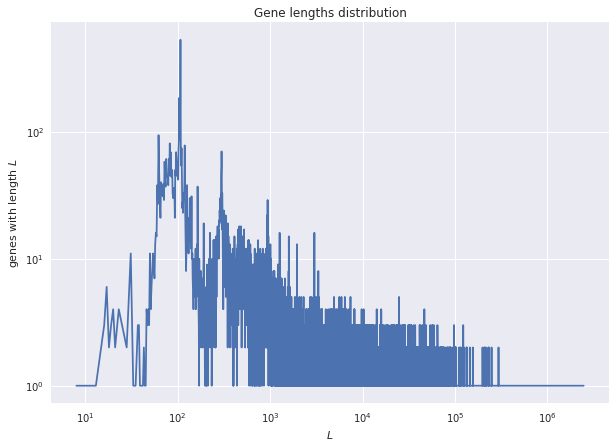

In [13]:
x = sorted(lengths_distribution.keys())
y = [lengths_distribution[i] for i in x]

plt.figure(figsize=(10, 7))

plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.title('Gene lengths distribution')
plt.xlabel('$L$')
plt.ylabel('genes with length $L$')

plt.savefig('gene-lengths.png')
plt.show()

In [14]:
lengths_distribution

Counter({2963: 2,
         1308: 4,
         1020: 8,
         34493: 1,
         86: 44,
         36466: 1,
         1596: 2,
         660: 5,
         282: 20,
         943: 7,
         11207: 1,
         8176: 1,
         146: 6,
         57459: 1,
         104: 185,
         20910: 1,
         174474: 1,
         978: 3,
         231363: 1,
         59196: 1,
         979: 7,
         164: 37,
         27606: 1,
         16895: 1,
         9326: 1,
         6718: 1,
         258991: 1,
         61: 27,
         16005: 1,
         118384: 1,
         6299: 1,
         381: 10,
         69711: 1,
         5101: 1,
         580: 14,
         416: 5,
         555: 6,
         399: 3,
         8285: 1,
         3325: 2,
         848: 7,
         52319: 1,
         93357: 1,
         524: 6,
         9265: 1,
         35919: 1,
         7405: 5,
         17740: 1,
         156: 12,
         87575: 1,
         5484: 1,
         95: 45,
         52447: 2,
         4087: 1,
         1122: 5